## Cycle extraction

Testing cycle extraction by iterating on cycle of extraction+subtraction

In [15]:
using  PyCall
using  Statistics , StatsBase
using  DataFrames, Printf , CSV , Query

import PyPlot
sns= pyimport("seaborn")

## directory
rootdir = ENV["GAIA_ROOT"]
wdir    = "$rootdir/products"
votdir  = "$wdir/votable.2020"
plotdir = "$wdir/test"
ocdir   = "$wdir/octest"
sclist  = "$rootdir/e2e_products/sc-list-2020.csv"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

cd(wdir)

In [16]:
function _getdata(filevot)
    voname = filevot

    println("## Data filtered in distance ..")
    data       = read_votable(voname)
    df         = filter_data(data,[0., 500])
    dfcart     = add_cartesian(df)

    return(df, dfcart)
end

_getdata (generic function with 1 method)

In [17]:
function _remove_stars(df, dfcart, idx)
    println(size(df.data))
    println("setdiff")
    println(size(df.data[:,setdiff(1:end,idx)]))
    s=size(df.data)
    println(size(df.data[:,setdiff(1:s[2],idx)]))
    diff= setdiff(1:s[2],idx)
    println(length(diff))
    
    println("end setdiff")
    
    dfdata= df.data[:,setdiff(1:end,idx)]
    dfraw= df.raw[:,setdiff(1:end,idx)]
    dferr= df.err[:,setdiff(1:end,idx)]
    
    dfcartdata= dfcart.data[:,setdiff(1:end,idx)]
    dfcartraw= dfcart.raw[:,setdiff(1:end,idx)]
    dfcarterr= dfcart.err[:,setdiff(1:end,idx)]
     
    s=size(dfdata)
    println("##ndata")
    println(s[2])
    println("##ndata")
    
    dfnew= GaiaClustering.Df(s[2],dfdata,dfraw,dferr)
    dfcartnew= GaiaClustering.Df(s[2],dfcartdata,dfcartraw,dfcarterr)
    
    println(size(dfnew.data))
    nrem= length(idx)
    println("### $nrem stars removed")
    return(dfnew, dfcartnew)
end

function _extraction_mcmc(mc)
    println("### testing mcmc results with median instead of mean...")
    
    epsm = median(mc.eps)
    epsd = std(mc.eps)
    mneim = median(mc.mne)
    mneid = std(mc.mne)
    mclm = median(mc.mcl)
    mcld = std(mc.mcl)
    qcm = median(mc.qc)
    qnm = median(mc.qn)
    qcd = std(mc.qc)
    qnd = std(mc.qn)
    w3dm = median(mc.w3d)
    w3dd = std(mc.w3d)
    wvelm = median(mc.wvel)
    wveld = std(mc.wvel)
    whrdm = median(mc.whrd)
    whrdd = std(mc.whrd)
    
    @printf("## DBSCAN/MCMC stats: \n")
    @printf("### ϵ : %3.3f +/- %3.3f \n", epsm, epsd)
    @printf("### min_nei  : %3.1f +/- %3.3f \n", mneim, mneid)
    @printf("### min_clus  : %3.1f +/- %3.3f \n", mclm, mcld)
    @printf("### W3d  : %3.3f +/- %3.3f \n", w3dm, w3dd)
    @printf("### Wvel  : %3.3f +/- %3.3f \n" , wvelm, wveld)
    @printf("### Whrd  : %3.3f +/- %3.3f \n", whrdm, whrdd)
    @printf("### Qn  : %3.3f +/- %3.3f \n",qnm, qnd)
    @printf("### Qc  : %3.3f +/- %3.3f \n",qcm, qcd)
    @printf("##")
    
    res = DataFrame(votname=votname, epsm = epsm, epsd=epsd, mneim=mneim,mneid=mneid,mclm=mclm,mcld=mcld,
            qcm=qcm,qcd=qcd, qnm=qnm,qnd=qnd,
            w3dm=w3dm,w3dd=w3dd,wvelm=wvelm,wveld=wveld,whrdm=whrdm,whrdd=whrdd)
    return(res)
end

function _score_cycle(qc, qn, nchain, iter)
    k= log10(qc*qn*nchain /iter)
    
    return(k)
end

_score_cycle (generic function with 1 method)

In [18]:
function _plot_check(dfcart)
    cart= DataFrame(X=dfcart.data[1,:], Y=dfcart.data[2,:], Z=dfcart.data[3,:])

    println("## check plot subtraction ...")
    
    PyPlot.plt.figure(figsize=(9.0,8.0))
    PyPlot.plt.subplot(1, 1, 1 , ylim=[100,450], xlim=[-50,50])
    PyPlot.plt.scatter(cart.Y, cart.X, s = 0.1 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("X (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.show()

end

_plot_check (generic function with 1 method)

In [19]:
## main cycle method

function _cycle_extraction(votname, m::GaiaClustering.meta)
    df, dfcart= _getdata(votdir*"/"*votname)
    
    cyclerun= true
    cycle= 1
    
    cyclemax= 2
    minstarselection= 50     # minimum of stars to select solution in a cycle...
    maxstarstop= 50          #condition to stop cycling
   
    
    while cyclerun
        println("##\n## Starting cycle $cycle ...")
        ## extraction one cycle.. MCMC optimization
        mc , iter, completed= abc_mcmc_dbscan_full2(dfcart, m)
        nchain= length(mc.qc)
        println("## $iter iterations performed...")
        if completed println("## optimization completed..") end
        
        # plot_dbscanfull_mcmc(plotdir, votname, mc , false)

        ## get the cluster and plot it
        println("## Extracting the cluster using DBSCAN/WEIGHTING with:")
        res2= _extraction_mcmc(mc)
        eps= res2.epsm[1]
        min_nei= trunc(Int,res2.mneim[1] + 0.5)
        min_cl= trunc(Int,res2.mclm[1] + 0.5)
        w3d= res2.w3dm[1]
        wvel= res2.wvelm[1]
        whrd= res2.whrdm[1]

        mres = GaiaClustering.modelfull(eps,min_nei,min_cl,w3d,wvel,whrd)
        dfcartnorm = getDfcartnorm(dfcart, mres)
        labels = clusters(dfcartnorm.data ,eps  , 20, min_nei, min_cl)
        labelmax , nmax, qc = find_cluster_label2(labels, df, dfcart)
        println("## Label $labelmax written to oc...")
        export_df("$votname.$cycle.0", ocdir, df , dfcart, labels , labelmax)
        scproperties0 = get_properties_SC(labels[labelmax] , df, dfcart)
        plot_cluster2(plotdir, "$votname.$cycle", labels[labelmax], scproperties0,  dfcart , false)
        println("### Label solution: $labelmax")
        println("### N stars: $nmax")
        println("### Qc: $qc")
        println("###")
        
         _plot_check(dfcart)
        
        k= _score_cycle(qc, nmax, nchain, iter)
        @printf("## Score cycle %d: %3.3f \n",cycle, k)
        
        println("### subtracting BEST solution from Df...")
                
        dfnew, dfcartnew= _remove_stars(df, dfcart, labels[labelmax])
        df= dfnew
        dfcart= dfcartnew
        
        if nmax < maxstarstop || cycle == cyclemax
            println("## Cycle stopped at $cycle")
            println("## Check the code!!!")
            cyclerun= false
        end
        cycle += 1
    end
end

_cycle_extraction (generic function with 1 method)

In [20]:
function main(votname, metafile)
    m= read_params(metafile)
    _cycle_extraction(votname, m)
end

main (generic function with 1 method)

## All parameters set to default...
Any["minQc", "=", 2.7]
Any["minQn", "=", 40]
Any["maxQn", "=", 5000]
Any["forcedminstars", "=", 30]
Any["mingoodsolution", "=", 10]
Any["niterqminq", "=", 500]
Any["nburnout", "=", 100]
Any["nchain", "=", 400]
Any["maxiter", "=", 2000]
Any["epsmean", "=", 2.5]
Any["epsdisp", "=", 1.5]
Any["min_nei", "=", 10]
Any["min_cl", "=", 15]
Any["ncoredisp", "=", 10]
Any["w3dmean", "=", 6.0]
Any["w3ddisp", "=", 4.0]
Any["wvelmean", "=", 6.0]
Any["wveldisp", "=", 4.0]
Any["whrdmean", "=", 2.0]
Any["whrddisp", "=", 1.5]
Any["aperture2d", "=", 1.5]
Any["maxaperture2d", "=", 15.0]
Any["aperture3d", "=", 3.0]
Any["maxaperture3d", "=", 20]
Any["aperturev", "=", 3.0]
Any["maxaperturev", "=", 20.0]
Any["nboot", "=", 50.0]
Any["labels", "=", "Qc"]
## Parameters read from test.ext
## Data filtered in distance ..
## Votable /home/stephane/Science/GAIA/products/votable.2020/NGC 869-3.0deg.vot read
## Filtering done ...
## Stars selected: 15192
## Cartesian transformation d

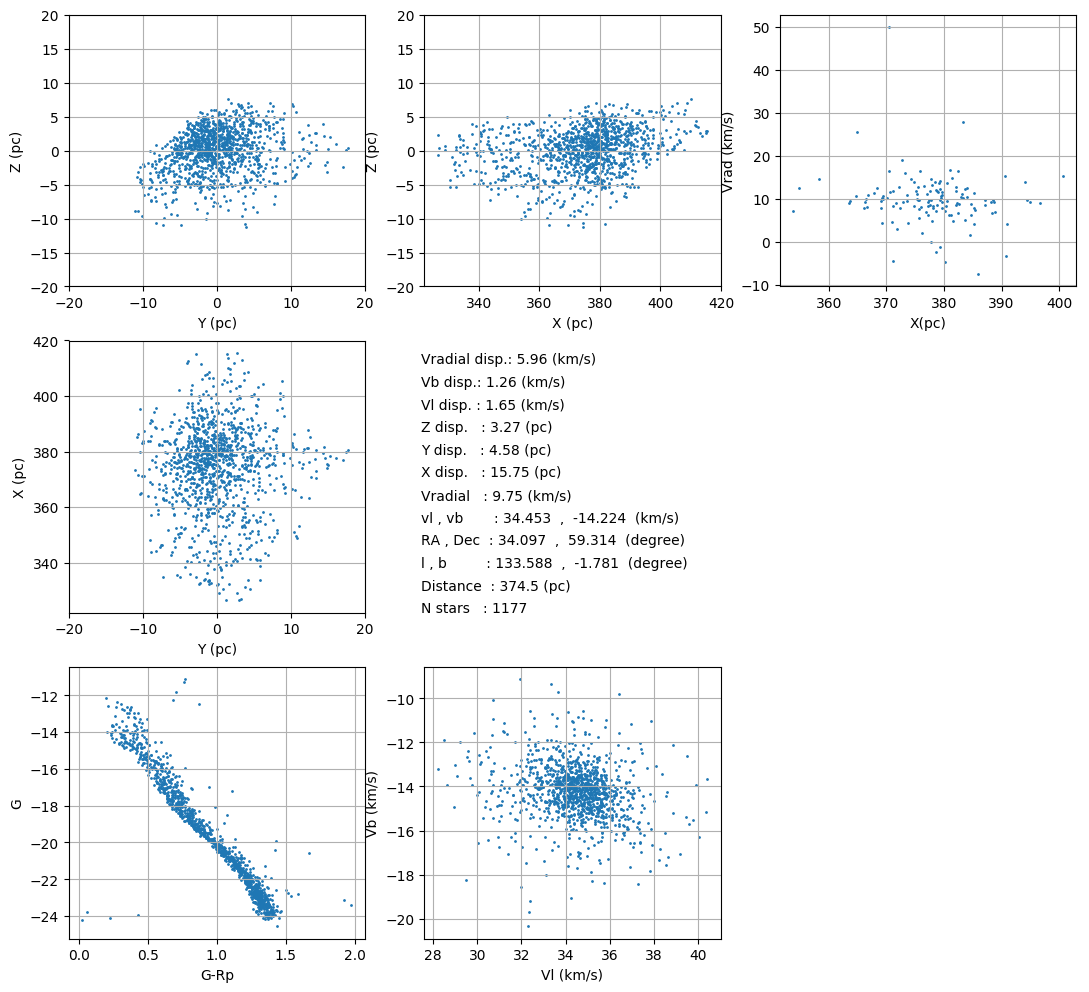

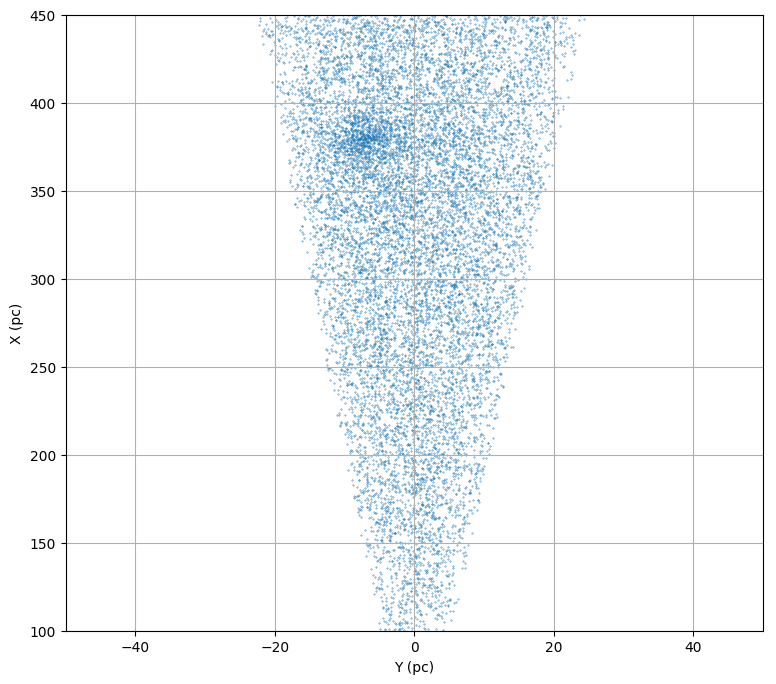

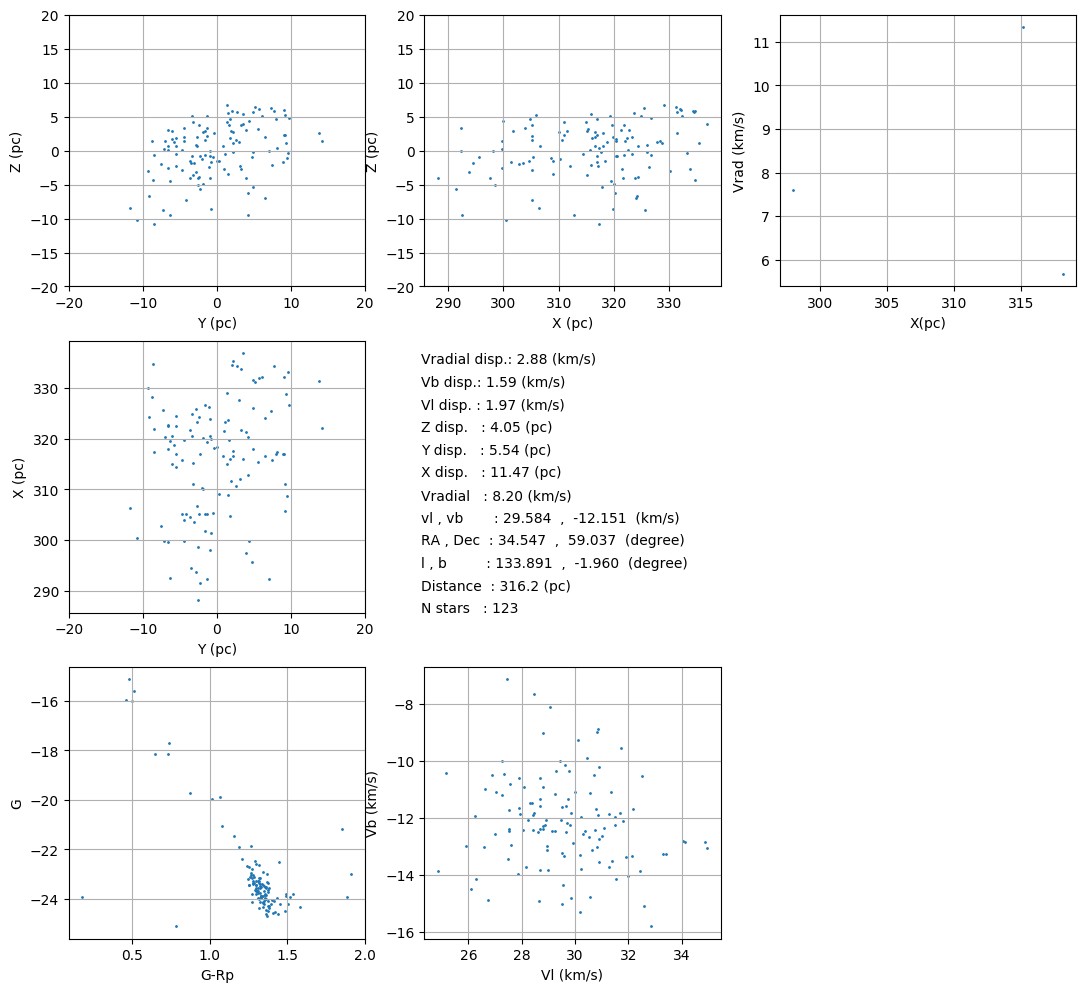

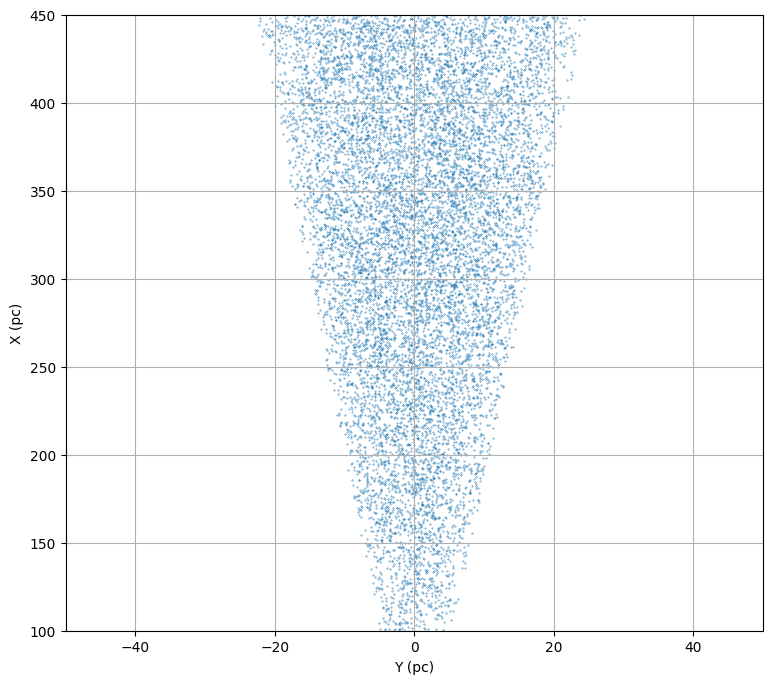


### N stars: 123
### Qc: 2.035934188773332
###
## check plot subtraction ...
## Score cycle 2: -0.425 
### subtracting BEST solution from Df...
(8, 14015)
setdiff
(8, 13892)
(8, 13892)
13892
end setdiff
##ndata
13892
##ndata
(8, 13892)
### 123 stars removed
## Cycle stopped at 2
## Check the code!!!


In [21]:
votname= "NGC 869-3.0deg.vot"
metafile= "test.ext"
main(votname, metafile)